In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib widget
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62']
block_lists = [[24, 26]]

# animals = ['PV_62'] \\ block_lists = [[23,24,25,26,27]]

# animals = ['PV_57']
# block_lists = [[1,2,3,4,5,6,7,8,9,10,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!


In [3]:
#More efficient caudal_rostral extraction:
# This bit of code goes over blocks and collects the median distance between the rostral and caudal edges
import os
from ellipse import LsqEllipse
import scipy.stats as stats

def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)

    # sort the pupil elements to dfs: x and y, with p as probability
  

    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320*2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    good_edge_points = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm.tqdm(range(1, len(data) - 1)):


        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)

    # ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    # a = np.array(ellipse_df['height'][:])
    # b = np.array(ellipse_df['width'][:])
    # ellipse_size_per_frame = a * b * math.pi
    # ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df = pd.DataFrame.from_dict({
        'rostral_edge':rostral_edge_ls,
        'caudal_edge': caudal_edge_ls
    })

    print(f'\n ellipses calculation complete')
    
    ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
    ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
    
    return ellipse_df

def get_pixel_distance(df):
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    mean_distance = np.nanmean(distances)
    std_distance = np.nanstd(distances)
    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(distances)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    
    # Kolmogorov-Smirnov Test
    ks_test = stats.kstest(distances, 'norm', args=(mean_distance, std_distance))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
    
    median_distance = np.median(distances)
    iqr_distance = stats.iqr(distances)
    print(f"Median Distance: {median_distance}")
    print(f"IQR: {iqr_distance}")
    print(f'mean = {mean_distance}')
    print(f'std = {std_distance}')
    return median_distance

R_pix_distance_dict = {}
L_pix_distance_dict = {}

for block in block_collection:
    print(f'working on {block}')
    pl = [i for i in os.listdir(block.r_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    R_csv  = pd.read_csv(block.r_e_path / pl, header=1)
    
    pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    L_csv  = pd.read_csv(block.l_e_path / pl, header=1)
    R_ellipse_df = eye_tracking_analysis(R_csv,0.998)
    print('working on the right eye')
    R_pixel_distance = get_pixel_distance(R_ellipse_df)    
    L_ellipse_df = eye_tracking_analysis(L_csv,0.998)
    print('working on the left eye')
    L_pixel_distance = get_pixel_distance(L_ellipse_df)
    R_pix_distance_dict[block.block_num] = R_pixel_distance
    L_pix_distance_dict[block.block_num] = L_pixel_distance
    

working on PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08


C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 74964/74964 [00:01<00:00, 65322.24it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8337621092796326, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.22513414582095348, p-value=0.0
Median Distance: 170.56265494082356
IQR: 187.62397951928207
mean = 122.15388709434797
std = 88.02842973875924


100%|██████████| 75160/75160 [00:01<00:00, 66816.08it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.3840610384941101, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.43686060881080435, p-value=0.0
Median Distance: 163.33067449407372
IQR: 8.442067801228774
mean = 174.8550673707375
std = 73.75575722479685
working on PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11


C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 82149/82149 [00:01<00:00, 68262.58it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7273547649383545, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.34298559050589594, p-value=0.0
Median Distance: 188.04504382391363
IQR: 29.046792216305676
mean = 159.01423533411204
std = 76.44637174462486


100%|██████████| 82570/82570 [00:01<00:00, 68457.07it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.7625982761383057, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.37518751172688103, p-value=0.0
Median Distance: 168.66390582214694
IQR: 18.6474879991261
mean = 210.06957162637528
std = 125.4860443017136
working on PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35


C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 87479/87479 [00:01<00:00, 70869.56it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7375690937042236, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.33596320293670495, p-value=0.0
Median Distance: 187.45653052096173
IQR: 159.63993399545558
mean = 144.24019108771478
std = 85.27411707024469


100%|██████████| 87428/87428 [00:01<00:00, 63587.52it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.6999752521514893, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.361852263529448, p-value=0.0
Median Distance: 166.05597178533827
IQR: 10.911466711966966
mean = 170.5868048161704
std = 97.31837406999608
working on PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28


C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 74966/74966 [00:01<00:00, 68539.15it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.6688728332519531, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3666217537384095, p-value=0.0
Median Distance: 189.39787074523161
IQR: 18.279647455407684
mean = 166.12599409663392
std = 71.09372607374901


100%|██████████| 75005/75005 [00:01<00:00, 72054.83it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.8767969608306885, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.18909306110061025, p-value=0.0
Median Distance: 165.2552295039783
IQR: 309.34040403621805
mean = 174.05458916603342
std = 137.46204762302474


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# This cell SHOULD go over blocks and update the block.L/R_pixel_size attribute according to the measured distance from the animal
real_distance = 7.8  # mm
export_now = True # ONLY SWITCH FLAG WHEN YOU ARE SURE YOU WANT TO OVERWRITE
for block in block_collection:
    block.calibrate_pixel_size(10)
    print(f'the previous calibration pixel sizes were: ')
    print(f'left = {block.L_pix_size} right = {block.R_pix_size}')
    print(f'the new calibration pixel sizes are: ')
    print(f'left = {real_distance / L_pix_distance_dict[block.block_num]} right = {real_distance / R_pix_distance_dict[block.block_num]}')
   
    block.L_pix_size = real_distance / L_pix_distance_dict[block.block_num]
    block.R_pix_size = real_distance / R_pix_distance_dict[block.block_num]
    internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
    internal_df.at[0, 'L_pix_size'] = block.L_pix_size
    internal_df.at[0, 'R_pix_size'] = block.R_pix_size
    
    if export_now:
        internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)
        print(f'exported to {block.analysis_path / "LR_pix_size.csv"}')
    else:
        print('this was not exported')

In [3]:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
        
        
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax 
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [ ]:
#1. initialize a subplots object with 2Xlen(block_collection)
#2. iterate over blocks and plot the pupil diameter distribution from block.left/right_eye_data.pupil_diameter with the block number as title
import matplotlib.pyplot as plt
import seaborn as sns

def compare_pupil_distributions(block_collection, export_path=None):
    """
    Plot pupil diameter distributions for each block in a 2-column layout (left and right eye).
    
    Parameters:
    - block_collection: List of blocks with calibrated pupil diameter data.
    - export_path: Path to save the plot as a PDF, if provided.
    """
    num_blocks = len(block_collection)
    fig, axes = plt.subplots(num_blocks, 2, figsize=(10, 5 * num_blocks), sharex=False, sharey=True)
    
    for idx, block in enumerate(block_collection):
        # Left eye distribution
        if 'pupil_diameter' in block.left_eye_data.columns:
            sns.kdeplot(
                block.left_eye_data['pupil_diameter'], 
                ax=axes[idx, 0], 
                color='blue', 
                fill=True, 
                alpha=0.5
            )
            axes[idx, 0].set_title(f"Block {block.block_num} - Left Eye", fontsize=10)
            axes[idx, 0].set_xlabel("Pupil Diameter (mm)", fontsize=8)
            axes[idx, 0].set_ylabel("Density", fontsize=8)
            axes[idx, 0].tick_params(axis='both', labelsize=8)
        
        # Right eye distribution
        if 'pupil_diameter' in block.right_eye_data.columns:
            sns.kdeplot(
                block.right_eye_data['pupil_diameter'], 
                ax=axes[idx, 1], 
                color='green', 
                fill=True, 
                alpha=0.5
            )
            axes[idx, 1].set_title(f"Block {block.block_num} - Right Eye", fontsize=10)
            axes[idx, 1].set_xlabel("Pupil Diameter (mm)", fontsize=8)
            axes[idx, 1].set_ylabel("Density", fontsize=8)
            axes[idx, 1].tick_params(axis='both', labelsize=8)
    
    # Adjust layout
    plt.tight_layout()
    
    # Export plot if a path is provided
    if export_path:
        plt.savefig(export_path, format='pdf')
    
    plt.show()

# Example usage:


# Example usage:
export_path = pathlib.Path("path/to/save/pupil_distributions.pdf")
compare_pupil_distributions(block_collection, export_path=None)


# Manual correction pipeline from here:

In [4]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd

def interactive_plot(block, eye, initial_calibration):
    """
    Displays an interactive plot for manual recalibration of a single block and eye.
    
    Parameters:
    - block: Block object containing eye data.
    - eye: 'left' or 'right' eye requiring recalibration.
    - initial_calibration: Initial calibration value for the specified eye.
    
    Returns:
    - Adjusted calibration value (float).
    """
    # Get pupil diameters for the specified eye
    if eye == 'left':
        pupil_diameters = block.left_eye_data['pupil_diameter_pixels'].values
    elif eye == 'right':
        pupil_diameters = block.right_eye_data['pupil_diameter_pixels'].values
    else:
        raise ValueError(f"Invalid eye value: {eye}. Expected 'left' or 'right'.")

    # Interactive adjustment
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.subplots_adjust(bottom=0.25)

    # Plot the pupil diameter distribution
    ax.hist(pupil_diameters * initial_calibration, bins=30, color='blue', alpha=0.6, edgecolor='black')
    ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye)", fontsize=10)
    ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

    # Add slider for manual adjustment
    ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03], facecolor='lightgoldenrodyellow')
    slider = Slider(ax_slider, 'Calibration', 0.001, 1, valinit=initial_calibration, valstep=0.01)

    def update(val):
        calibration = slider.val
        corrected_pupil_diameters = pupil_diameters * calibration
        ax.clear()
        ax.hist(corrected_pupil_diameters, bins=30, color='blue', alpha=0.6, edgecolor='black')
        ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye)", fontsize=10)
        ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
        ax.set_ylabel('Frequency', fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
        fig.canvas.draw_idle()

    slider.on_changed(update)
    plt.show()  

    # Retrieve the adjusted calibration value
    adjusted_calibration = slider.val
    return adjusted_calibration

def update_calibration_values(L_pix_distance_dict, R_pix_distance_dict, manual_recalibration):
    """
    Updates calibration dictionaries based on the manual_recalibration DataFrame.
    
    Parameters:
    - L_pix_distance_dict: Dictionary of left-eye pixel distances, indexed by block number.
    - R_pix_distance_dict: Dictionary of right-eye pixel distances, indexed by block number.
    - manual_recalibration: DataFrame with columns ['block', 'eye', 'calibration'] containing updates.
    
    Returns:
    - Updated L_pix_distance_dict and R_pix_distance_dict.
    """
    for _, row in manual_recalibration.iterrows():
        block = row['block']
        eye = row['eye']
        calibration = row['calibration']

        if eye == 'left':
            L_pix_distance_dict[block] = calibration
        elif eye == 'right':
            R_pix_distance_dict[block] = calibration
        else:
            raise ValueError(f"Invalid eye value: {eye}. Expected 'left' or 'right'.")

    return L_pix_distance_dict, R_pix_distance_dict
 

Initialization

In [5]:
import pandas as pd

# Initialize an empty DataFrame to store manual recalibration data
manual_recalibration = pd.DataFrame(columns=['block', 'eye', 'calibration'])

# Print the structure for verification
print(manual_recalibration)


Empty DataFrame
Columns: [block, eye, calibration]
Index: []


In [6]:
for block in block_collection:
    block.calibrate_pixel_size(10)

got the calibration values from the analysis folder
got the calibration values from the analysis folder


In [18]:
block

BlockSync object for animal PV_62 with 
block_num 024 at date 2023-04-27_11-22-56

In [19]:
block.left_eye_data['pupil_diameter_pixels'] = (block.left_eye_data['pupil_diameter_pixels'] / 2) / np.pi
block.right_eye_data['pupil_diameter_pixels'] = (block.right_eye_data['pupil_diameter_pixels'] / 2) / np.pi

block_dict.keys()

dict_keys(['PV_62_block_024', 'PV_62_block_026'])

go block-by-block for calibration (manually edit block num and eye)

In [16]:
# ONLY FOR EYE DATAFRAME EXPORT!!!
# name_tag = 'degrees_raw_verified'
# print(block.analysis_path / f'right_eye_data_{name_tag}.csv')
# block.right_eye_data.to_csv(block.analysis_path / f'right_eye_data_{name_tag}.csv')
# block.left_eye_data.to_csv(block.analysis_path / f'left_eye_data_{name_tag}.csv')

Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis\right_eye_data_degrees_raw_verified.csv


In [11]:
block

BlockSync object for animal PV_62 with 
block_num 026 at date 2023-04-27_12-21-41

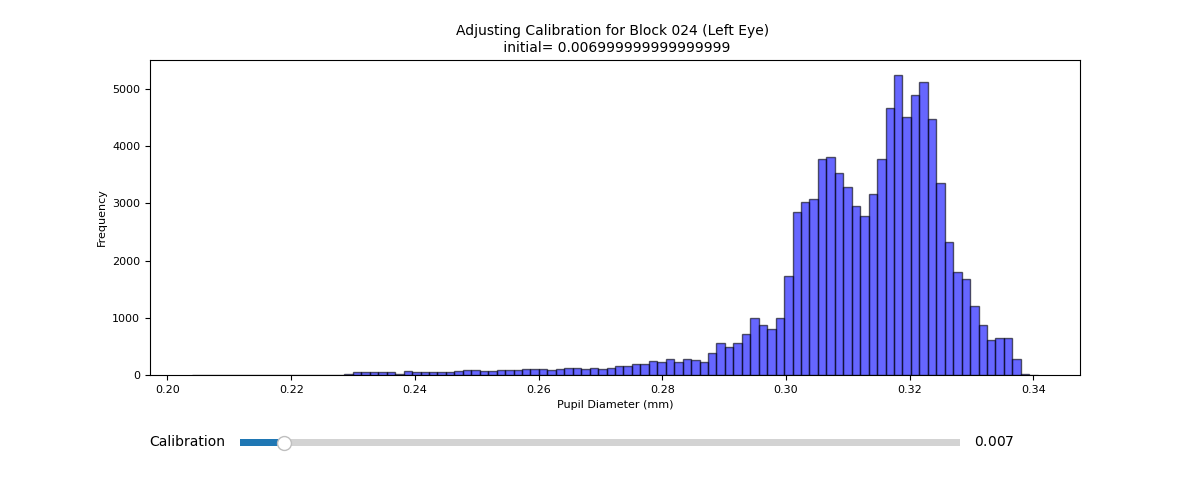

In [22]:
from matplotlib.widgets import Slider

# Example block and eye for recalibration
# Replace with the block number you are recalibrating
block_num = '024'
block_key = f'PV_62_block_{block_num}'
# Replace with 'left' or 'right' based on the eye
eye = 'left'

# Get the block object and initial calibration
block = block_dict[block_key]
initial_calibration = block.L_pix_size if eye == 'left' else block.R_pix_size

if eye == 'left':
    pupil_diameters = block.left_eye_data['pupil_diameter_pixels'].values
elif eye == 'right':
    pupil_diameters = block.right_eye_data['pupil_diameter_pixels'].values
else:
    raise ValueError(f"Invalid eye value: {eye}. Expected 'left' or 'right'.")

# Interactive adjustment
fig, ax = plt.subplots(figsize=(12, 5))
plt.subplots_adjust(bottom=0.25)

# Plot the pupil diameter distribution
ax.hist(pupil_diameters * initial_calibration, bins=100, color='blue', alpha=0.6, edgecolor='black')
ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye) \n initial= {initial_calibration}", fontsize=10)
ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
ax.set_ylabel('Frequency', fontsize=8)
ax.tick_params(axis='both', labelsize=8)
#ax.set_yscale('log')
# Add custom x-axis ticks
#x_ticks = np.arange(0, max(pupil_diameters * initial_calibration) + 1, step=0.5)  # Adjust the range and step size as needed
#ax.set_xticks(x_ticks)
# Add slider for manual adjustment
ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Calibration', 0.001, 0.1, valinit=initial_calibration, valstep=0.0001)

def update(val):
    calibration = slider.val
    corrected_pupil_diameters = pupil_diameters * calibration
    ax.clear()
    ax.hist(corrected_pupil_diameters, bins=100, color='blue', alpha=0.6, edgecolor='black')
    ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye)", fontsize=10)
    ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    # ax.set_yscale('log')
    # ax.set_ylim(0,3000)
    #x_ticks = np.arange(np.nanmean(pupil_diameters *calibration) - np.nanstd(pupil_diameters*calibration)*10, np.nanmean(pupil_diameters * calibration) + np.nanstd(pupil_diameters*calibration)*10, step=1)  # Adjust the range and step size as needed
    #ax.set_xticks(x_ticks)
    ax.set_xlim(left=1,right=2.5)
    fig.canvas.draw_idle()
    return 

slider.on_changed(update)
plt.show()

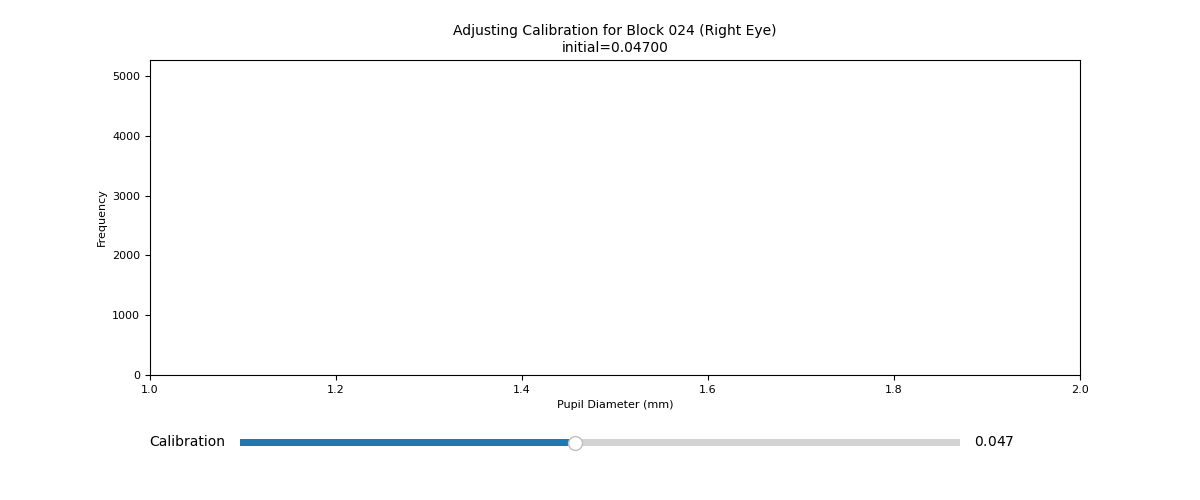

In [12]:
# Use interactive backend if you want live sliders
# %matplotlib widget

from matplotlib.widgets import Slider
import numpy as np
import matplotlib.pyplot as plt

# --- close any previously opened instance of this figure ---
plt.close('pupil-calibration-fig')   # closes by figure label (safe, targeted)

# Example block and eye for recalibration
block_num = '024'
block_key = f'PV_62_block_{block_num}'
eye = 'right'

block = block_dict[block_key]
initial_calibration = block.L_pix_size if eye == 'left' else block.R_pix_size

if eye == 'left':
    pupil_diameters = block.left_eye_data['pupil_diameter_pixels'].values
elif eye == 'right':
    pupil_diameters = block.right_eye_data['pupil_diameter_pixels'].values
else:
    raise ValueError("eye must be 'left' or 'right'")

# --- create/reuse a named figure so repeated runs don't accumulate ---
fig, ax = plt.subplots(figsize=(12, 5), num='pupil-calibration-fig')
fig.clf()                      # clear any old content in this figure
ax = fig.add_subplot(111)
fig.subplots_adjust(bottom=0.25)

# initial plot
ax.hist(pupil_diameters * initial_calibration, bins=100, color='blue', alpha=0.6, edgecolor='black')
ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye)\ninitial={initial_calibration:.5f}", fontsize=10)
ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
ax.set_ylabel('Frequency', fontsize=8)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlim(left=1, right=2)

# slider
ax_slider = fig.add_axes([0.2, 0.1, 0.6, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Calibration', 0.001, 0.1, valinit=initial_calibration, valstep=0.0001)

def update(val):
    calibration = slider.val
    ax.clear()
    ax.hist(pupil_diameters * calibration, bins=100, color='blue', alpha=0.6, edgecolor='black')
    ax.set_title(f"Adjusting Calibration for Block {block.block_num} ({eye.capitalize()} Eye)\ncurrent={calibration:.5f}", fontsize=10)
    ax.set_xlabel('Pupil Diameter (mm)', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_xlim(left=1, right=2)
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

# Optional: if you just want to silence the warning (not recommended as the only fix)
# from matplotlib import rcParams
# rcParams['figure.max_open_warning'] = 0


In [23]:
new_calibration = 0.045
# Append the new calibration value to the manual_recalibration DataFrame
manual_recalibration = manual_recalibration.append({
    'block': block_num,
    'eye': eye,
    'calibration': new_calibration
}, ignore_index=True)

# Display the updated manual_recalibration DataFrame
print(manual_recalibration)

  block    eye  calibration
0   026   left        0.045
1   026  right        0.045
2   024  right        0.045
3   024   left        0.045


Run this after all blocks are taken care of:

In [24]:
# Update pixel calibration values in the blocks based on manual_recalibration
for _, row in manual_recalibration.iterrows():
    block_key = f"PV_62_block_{row['block']}"  # Generate block key from block number
    eye = row['eye']
    calibration = row['calibration']

    # Access the block
    if block_key not in block_dict:
        raise KeyError(f"Block {block_key} not found in block_dict!")
    
    block = block_dict[block_key]

    # Update calibration for the specified eye
    if eye == 'left':
        block.L_pix_size = calibration
        print(f"Updated left eye calibration for Block {block_key} to {calibration:.6f}")
    elif eye == 'right':
        block.R_pix_size = calibration
        print(f"Updated right eye calibration for Block {block_key} to {calibration:.6f}")
    else:
        raise ValueError(f"Invalid eye value: {eye}. Expected 'left' or 'right'.")

# Verify the updated blocks
print("Updated blocks with new calibration values:")
for block_key, block in block_dict.items():
    print(f"{block_key}: L_pix_size={block.L_pix_size}, R_pix_size={block.R_pix_size}")


Updated left eye calibration for Block PV_62_block_026 to 0.045000
Updated right eye calibration for Block PV_62_block_026 to 0.045000
Updated right eye calibration for Block PV_62_block_024 to 0.045000
Updated left eye calibration for Block PV_62_block_024 to 0.045000
Updated blocks with new calibration values:
PV_62_block_024: L_pix_size=0.045, R_pix_size=0.045
PV_62_block_026: L_pix_size=0.045, R_pix_size=0.045


In [25]:
# pupil_diameter update step:
for block in block_collection:
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

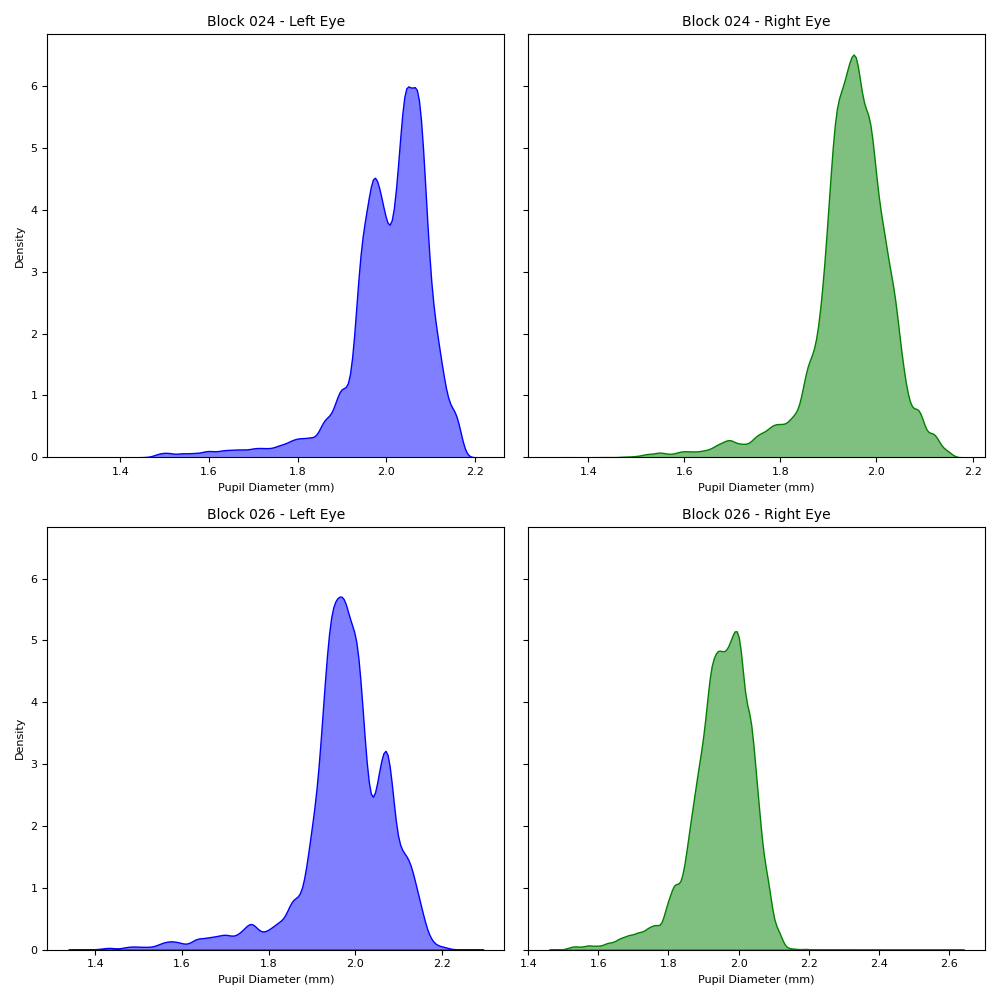

In [26]:
#1. initialize a subplots object with 2Xlen(block_collection)
#2. iterate over blocks and plot the pupil diameter distribution from block.left/right_eye_data.pupil_diameter with the block number as title
import matplotlib.pyplot as plt
import seaborn as sns

def compare_pupil_distributions(block_collection, export_path=None):
    """
    Plot pupil diameter distributions for each block in a 2-column layout (left and right eye).
    
    Parameters:
    - block_collection: List of blocks with calibrated pupil diameter data.
    - export_path: Path to save the plot as a PDF, if provided.
    """
    num_blocks = len(block_collection)
    fig, axes = plt.subplots(num_blocks, 2, figsize=(10, 5 * num_blocks), sharex=False, sharey=True)
    
    for idx, block in enumerate(block_collection):
        # Left eye distribution
        if 'pupil_diameter' in block.left_eye_data.columns:
            sns.kdeplot(
                block.left_eye_data['pupil_diameter'], 
                ax=axes[idx, 0], 
                color='blue', 
                fill=True, 
                alpha=0.5
            )
            axes[idx, 0].set_title(f"Block {block.block_num} - Left Eye", fontsize=10)
            axes[idx, 0].set_xlabel("Pupil Diameter (mm)", fontsize=8)
            axes[idx, 0].set_ylabel("Density", fontsize=8)
            axes[idx, 0].tick_params(axis='both', labelsize=8)
        
        # Right eye distribution
        if 'pupil_diameter' in block.right_eye_data.columns:
            sns.kdeplot(
                block.right_eye_data['pupil_diameter'], 
                ax=axes[idx, 1], 
                color='green', 
                fill=True, 
                alpha=0.5
            )
            axes[idx, 1].set_title(f"Block {block.block_num} - Right Eye", fontsize=10)
            axes[idx, 1].set_xlabel("Pupil Diameter (mm)", fontsize=8)
            axes[idx, 1].set_ylabel("Density", fontsize=8)
            axes[idx, 1].tick_params(axis='both', labelsize=8)
    
    # Adjust layout
    plt.tight_layout()
    
    # Export plot if a path is provided
    if export_path:
        plt.savefig(export_path, format='pdf')
    
    plt.show()

# Example usage:


# Example usage:
export_path = pathlib.Path("path/to/save/pupil_distributions.pdf")
compare_pupil_distributions(block_collection, export_path=None)


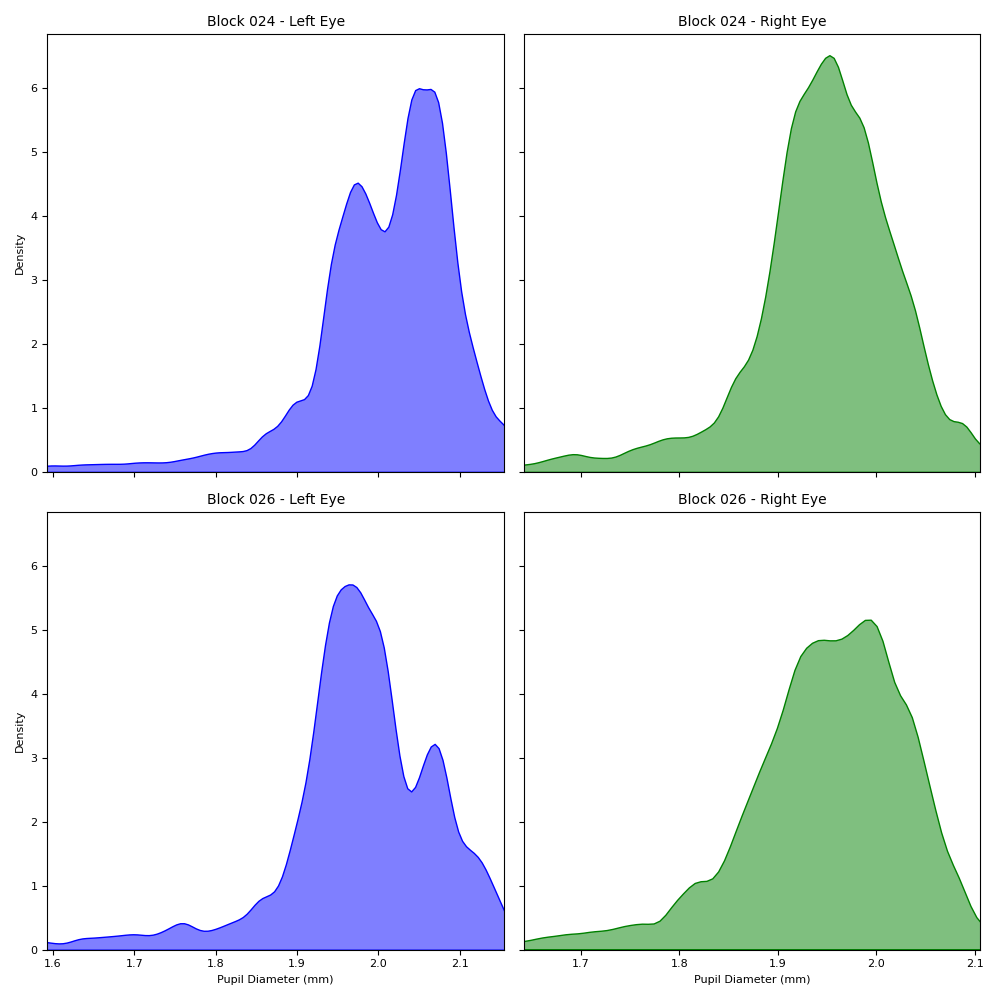

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compare_pupil_distributions(block_collection, export_path=None):
    """
    Plot pupil diameter distributions for each block in a 2-column layout (left and right eye).
    
    Parameters:
    - block_collection: List of blocks with calibrated pupil diameter data.
    - export_path: Path to save the plot as a PDF, if provided.
    """
    num_blocks = len(block_collection)
    fig, axes = plt.subplots(num_blocks, 2, figsize=(10, 5 * num_blocks), sharex='col', sharey=True)

    # Collect valid pupil diameters to compute x-axis range
    all_left_diameters = []
    all_right_diameters = []

    for block in block_collection:
        # Check and collect valid left eye data
        if 'pupil_diameter' in block.left_eye_data.columns:
            valid_left = block.left_eye_data['pupil_diameter'].dropna()
            if not valid_left.empty:
                all_left_diameters.extend(valid_left)

        # Check and collect valid right eye data
        if 'pupil_diameter' in block.right_eye_data.columns:
            valid_right = block.right_eye_data['pupil_diameter'].dropna()
            if not valid_right.empty:
                all_right_diameters.extend(valid_right)

    # Compute x-axis range (1st and 99th percentiles) for valid data
    if all_left_diameters:
        left_min, left_max = np.percentile(all_left_diameters, [1, 99])
    else:
        left_min, left_max = None, None

    if all_right_diameters:
        right_min, right_max = np.percentile(all_right_diameters, [1, 99])
    else:
        right_min, right_max = None, None

    for idx, block in enumerate(block_collection):
        # Left eye distribution
        if 'pupil_diameter' in block.left_eye_data.columns:
            valid_left = block.left_eye_data['pupil_diameter'].dropna()
            if not valid_left.empty:
                sns.kdeplot(
                    valid_left, 
                    ax=axes[idx, 0], 
                    color='blue', 
                    fill=True, 
                    alpha=0.5
                )
                axes[idx, 0].set_title(f"Block {block.block_num} - Left Eye", fontsize=10)
                axes[idx, 0].set_xlabel("Pupil Diameter (mm)", fontsize=8)
                axes[idx, 0].set_ylabel("Density", fontsize=8)
                axes[idx, 0].tick_params(axis='both', labelsize=8)
                if left_min is not None and left_max is not None:
                    axes[idx, 0].set_xlim(left_min, left_max)  # Apply shared x-axis range

        # Right eye distribution
        if 'pupil_diameter' in block.right_eye_data.columns:
            valid_right = block.right_eye_data['pupil_diameter'].dropna()
            if not valid_right.empty:
                sns.kdeplot(
                    valid_right, 
                    ax=axes[idx, 1], 
                    color='green', 
                    fill=True, 
                    alpha=0.5
                )
                axes[idx, 1].set_title(f"Block {block.block_num} - Right Eye", fontsize=10)
                axes[idx, 1].set_xlabel("Pupil Diameter (mm)", fontsize=8)
                axes[idx, 1].set_ylabel("Density", fontsize=8)
                axes[idx, 1].tick_params(axis='both', labelsize=8)
                if right_min is not None and right_max is not None:
                    axes[idx, 1].set_xlim(right_min, right_max)  # Apply shared x-axis range
    
    # Adjust layout
    plt.tight_layout()
    
    # Export plot if a path is provided
    if export_path:
        plt.savefig(export_path, format='pdf')
    
    plt.show()

export_path = pathlib.Path("path/to/save/pupil_distributions.pdf")
compare_pupil_distributions(block_collection, export_path=None)

In [28]:
# CAREFUL!!! This is the overwrite step for corrected calibration and will remove previous pixel calibration values for the block
overwrite=True
for block in block_collection:
    internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
    internal_df.at[0, 'L_pix_size'] = block.L_pix_size
    internal_df.at[0, 'R_pix_size'] = block.R_pix_size
    if overwrite:
        internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)
        print(f'exported to {block.analysis_path / "LR_pix_size.csv"}')
    else:
        print('if you really want to, set overwrite=True')

exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis\LR_pix_size.csv


In [29]:
block.left_eye_data.columns

Index(['OE_timestamp', 'eye_frame', 'ms_axis', 'center_x', 'center_y',
       'ellipse_phi', 'width', 'height', 'major_ax', 'minor_ax', 'ratio',
       'xgb_theta', 'xgb_phi', 'phi', 'theta', 'pupil_diameter_pixels',
       'pupil_diameter'],
      dtype='object')